In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import random
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import binarize
from sklearn.metrics import classification_report
import joblib

In [2]:
df = pd.read_csv('epi_r.csv')
join_df = pd.read_json('train.json')

In [3]:
df.dropna(inplace=True)
join_df.dropna(inplace=True)
df.set_index('title', inplace=True)
join_df.set_index('title', inplace=True)
df = df.loc[join_df.index]

C:\Users\marc.ribalta\AppData\Local\Continuum\anaconda3\envs\SIGNN\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """


In [40]:
df.head()

,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
title,,,,,,,,,,,,,,,,,,,,,
Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Best Blts,4.375,948.0,19.0,79.0,1042.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Korean Marinated Beef,4.375,170.0,7.0,10.0,1272.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ham Persillade with Mustard Potato Salad and Mashed Peas,3.750,602.0,23.0,41.0,1696.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Yams Braised with Cream, Rosemary and Nutmeg",3.750,256.0,4.0,5.0,30.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
ITERATIONS = 4 # Numero de cops que es fa la iteracio
columns = df.columns[11:].tolist()
final_df = pd.DataFrame(columns = columns+['num_ing','rating', 'ratings_cli'])
df.dropna(inplace=True)
for ind in range(df.index.size):
    row = df.iloc[ind]
    if row.rating > 2.5:
        ma = 5
        mi = row.rating - (5-row.rating)
    else:
        ma = row.rating * 2
        mi = 0
    if (ma-mi)==0:
        ratings = [5] * 10 if ma==5 else [0] * 10
    else:
        ratings = np.arange(mi, ma, (ma-mi)/ITERATIONS)
    ingredients = row[11:]
    for i in range(1, ITERATIONS+1):
        available = ingredients[ingredients == 1]
        num_ing = int((len(available) * i)/ITERATIONS)
        num_ing = 1 if num_ing==0 and len(available)!=0 else num_ing
        temp = pd.DataFrame([[0]*668],columns = columns)
        temp[columns] = ingredients.values
        temp['num_ing'] = num_ing
        temp['rating'] = row['rating']
        temp['ratings_cli'] = ratings[i-1]
        final_df = final_df.append(temp)

KeyboardInterrupt: 

In [ ]:
final_df.to_csv('final_df.csv')

# Preparem per predir

Si tenim un usuari que li agraden els ingredients 1..n, li agradara aquesta recepta?

Per formular això, tenim un historic d'usuaris valoran una recepta, tenint els ingredients que li agraden al usuari en especific. Per tant tindrem nom de recepta, rating que li ha donat l'usuari, ingredients que li agraden al usuari i finalment la variable objectiu serà si li agradà a l'usuari o no. 

Per fer el train, assumirem que si un usuari ha fet un rating de més de 4, vol dir que li agrada la recepta,

Per crear opinions dels usuaris, tindrem que els millors casos son rating 5 i que tots els ingredients de la recepta li agraden al usuari. Per tant podem quadrar el numero de ingredients que li agraden a una persona tenint en compte els ingredients necessaris per fer una recepta. Mirarem primer de tot els ingredients necessaris per fer una recepta i crearem usuaris amb ingredients que agraden, de 100% i anar reduint fins a 0%. Recordem que s'ha d'afegir un factor random, i que algunes de les opinions tindran un factor random, per aixi perdre correlació.

In [3]:
final_df = pd.read_csv('final_df.csv')

In [6]:
final_df['y'] = [1 if rate > 4 else 0 for rate in final_df.ratings_cli]

In [9]:
del final_df['Unnamed: 0']
del final_df['ratings_cli']

In [20]:
X = final_df.loc[:, final_df.columns != 'y']
y = final_df.y

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [47]:
final_df.head()

,alabama,alaska,alcoholic,almond,amaretto,anchovy,anise,anniversary,anthony bourdain,aperitif,...,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey,num_ing,rating,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,4.375,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,4.375,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,4.375,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,4.375,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,4.375,0


# Function to tune the model

In [34]:
def evalClassModel(model, y_test, y_pred_class, plot=False):
    #Classification accuracy: percentage of correct predictions
    # calculate accuracy
    print('Accuracy:', metrics.accuracy_score(y_test, y_pred_class))
    
    #Null accuracy: accuracy that could be achieved by always predicting the most frequent class
    # examine the class distribution of the testing set (using a Pandas Series method)
    print('Null accuracy:\n', y_test.value_counts())
    
    # calculate the percentage of ones
    print('Percentage of ones:', y_test.mean())
    
    # calculate the percentage of zeros
    print('Percentage of zeros:',1 - y_test.mean())
    
    #Comparing the true and predicted response values
    print('True:', y_test.values[0:25])
    print('Pred:', y_pred_class[0:25])
    
    #Conclusion:
    #Classification accuracy is the easiest classification metric to understand
    #But, it does not tell you the underlying distribution of response values
    #And, it does not tell you what "types" of errors your classifier is making
    
    #Confusion matrix
    # save confusion matrix and slice into four pieces
    confusion = metrics.confusion_matrix(y_test, y_pred_class)
    #[row, column]
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    
    # visualize Confusion Matrix
    sns.heatmap(confusion,annot=True,fmt="d") 
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    #Metrics computed from a confusion matrix
    #Classification Accuracy: Overall, how often is the classifier correct?
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    print('Classification Accuracy:', accuracy)
    
    #Classification Error: Overall, how often is the classifier incorrect?
    print('Classification Error:', 1 - metrics.accuracy_score(y_test, y_pred_class))
    
    #False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
    false_positive_rate = FP / float(TN + FP)
    print('False Positive Rate:', false_positive_rate)
    
    #Precision: When a positive value is predicted, how often is the prediction correct?
    print('Precision:', metrics.precision_score(y_test, y_pred_class))
    
    
    # IMPORTANT: first argument is true values, second argument is predicted probabilities
    print('AUC Score:', metrics.roc_auc_score(y_test, y_pred_class))
    
    # calculate cross-validated AUC
    print('Cross-validated AUC:', cross_val_score(model, X, y, cv=10, scoring='roc_auc').mean())
    
    print(classification_report(y_test, y_pred_class))
    
    ##########################################
    #Adjusting the classification threshold
    ##########################################
    # print the first 10 predicted responses
    # 1D array (vector) of binary values (0, 1)
    print('First 10 predicted responses:\n', model.predict(X_test)[0:10])

    # print the first 10 predicted probabilities of class membership
    print('First 10 predicted probabilities of class members:\n', model.predict_proba(X_test)[0:10])

    # print the first 10 predicted probabilities for class 1
    model.predict_proba(X_test)[0:10, 1]
    
    # store the predicted probabilities for class 1
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    if plot == True:
        # histogram of predicted probabilities
        # adjust the font size 
        plt.rcParams['font.size'] = 12
        # 8 bins
        plt.hist(y_pred_prob, bins=8)
        
        # x-axis limit from 0 to 1
        plt.xlim(0,1)
        plt.title('Histogram of predicted probabilities')
        plt.xlabel('Predicted probability of treatment')
        plt.ylabel('Frequency')
    
    
    # predict treatment if the predicted probability is greater than 0.3
    # it will return 1 for all values above 0.3 and 0 otherwise
    # results are 2D so we slice out the first column
    y_pred_prob = y_pred_prob.reshape(-1,1) 
    y_pred_class = binarize(y_pred_prob, 0.3)[0]
    
    # print the first 10 predicted probabilities
    print('First 10 predicted probabilities:\n', y_pred_prob[0:10])
    
    ##########################################
    #ROC Curves and Area Under the Curve (AUC)
    ##########################################
    
    #Question: Wouldn't it be nice if we could see how sensitivity and specificity are affected by various thresholds, without actually changing the threshold?
    #Answer: Plot the ROC curve!
    
    
    #AUC is the percentage of the ROC plot that is underneath the curve
    #Higher value = better classifier
    roc_auc = metrics.roc_auc_score(y_test, y_pred_prob)
    
    

    # IMPORTANT: first argument is true values, second argument is predicted probabilities
    # we pass y_test and y_pred_prob
    # we do not use y_pred_class, because it will give incorrect results without generating an error
    # roc_curve returns 3 objects fpr, tpr, thresholds
    # fpr: false positive rate
    # tpr: true positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
    if plot == True:
        plt.figure()
        
        plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for treatment classifier')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.show()
    
    # define a function that accepts a threshold and prints sensitivity and specificity
    def evaluate_threshold(threshold):
        #Sensitivity: When the actual value is positive, how often is the prediction correct?
        #Specificity: When the actual value is negative, how often is the prediction correct?print('Sensitivity for ' + str(threshold) + ' :', tpr[thresholds > threshold][-1])
        print('Specificity for ' + str(threshold) + ' :', 1 - fpr[thresholds > threshold][-1])

    # One way of setting threshold
    predict_mine = np.where(y_pred_prob > 0.50, 1, 0)
    confusion = metrics.confusion_matrix(y_test, predict_mine)
    print(confusion)
    
    
    
    return accuracy

In [40]:
def logisticRegression(X_train, X_test, y_train, y_test):
    # train a logistic regression model on the training set
    logreg = LogisticRegression(solver='liblinear', n_jobs=-1)
    logreg.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = logreg.predict(X_test)
    
    print('########### Logistic Regression ###############')
    
    accuracy_score = evalClassModel(logreg, y_test, y_pred_class, True)
    joblib.dump(logreg, 'logreg.joblib')

C:\Users\marc.ribalta\AppData\Local\Continuum\anaconda3\envs\SIGNN\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


########### Logistic Regression ###############
Accuracy: 0.9482245933181739
Null accuracy:
 1    6262
0    5172
Name: y, dtype: int64
Percentage of ones: 0.5476648591918839
Percentage of zeros: 0.4523351408081161
True: [0 1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 1 0 0 1 1 0 0 1]
Pred: [1 1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 1 0 0 1 1 0 0 1]


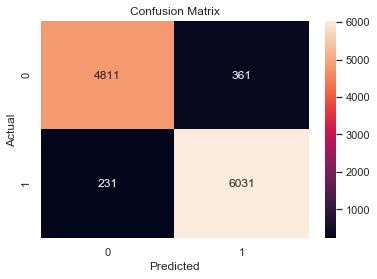

Classification Accuracy: 0.9482245933181739
Classification Error: 0.05177540668182612
False Positive Rate: 0.06979891724671307
Precision: 0.943523153942428
AUC Score: 0.9466559549825202
Cross-validated AUC: 0.9874892757752258
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      5172
           1       0.94      0.96      0.95      6262

   micro avg       0.95      0.95      0.95     11434
   macro avg       0.95      0.95      0.95     11434
weighted avg       0.95      0.95      0.95     11434

First 10 predicted responses:
 [1 1 1 0 0 1 1 1 0 0]
First 10 predicted probabilities of class members:
 [[3.77392308e-01 6.22607692e-01]
 [1.55802286e-01 8.44197714e-01]
 [3.89250624e-02 9.61074938e-01]
 [6.52360920e-01 3.47639080e-01]
 [6.72174222e-01 3.27825778e-01]
 [3.80737500e-03 9.96192625e-01]
 [5.79332355e-03 9.94206676e-01]
 [3.55331056e-02 9.64466894e-01]
 [9.99601289e-01 3.98711475e-04]
 [6.96722220e-01 3.03277780e-01]]
First 10 pr

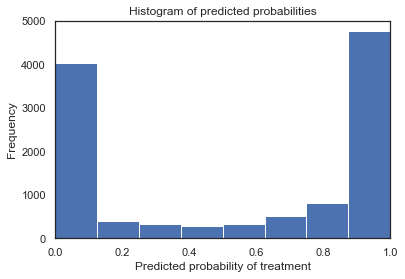

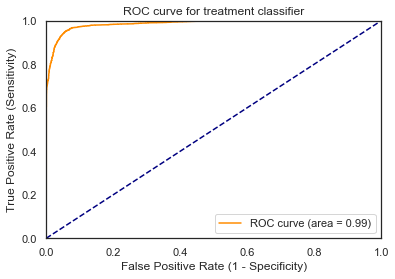

[[4811  361]
 [ 231 6031]]


In [41]:
logisticRegression(X_train, X_test, y_train, y_test)